In [1]:
import os
import numpy as np
import pydicom
import tensorflow as tf
from skimage.transform import resize
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
#from keras.src import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers.schedules import CosineDecay

from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

In [2]:

# Paths
image_path_base = r'C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\png'
text_path_base = r'C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\myver_cleanCropCMMD.csv'

def get_image_paths_and_labels():
    image_paths = []
    labels = []
    b_count = 0
    m_count = 0

    with open(text_path_base) as f:
        f.readline()

        for line in f:
            splitLine = line.split(",")

            imagePath = splitLine[2].replace("\n", "").replace('"',"") 
            image_paths.append(imagePath)

            classification = splitLine[1].replace('"', '') 
            if classification == "0":
              labels.append(np.array([0]))
              b_count += 1
            if classification == "1":
              labels.append(np.array([1]))
              m_count += 1

    print(f"Benign count: {b_count}")
    print(f"Malignant count: {m_count}")
    return np.array(image_paths), np.array(labels)

image_paths, labels = get_image_paths_and_labels()

# separate benign and malignant paths
benign_paths = image_paths[labels.flatten() == 0]
malignant_paths = image_paths[labels.flatten() == 1]

# Balance the dataset
num_to_augment = len(malignant_paths) - len(benign_paths)
print(f"\nNeed to augment {num_to_augment} benign images.")



# paths_train, paths_test, y_train, y_test = train_test_split(
#     image_paths, labels, test_size=0.2, random_state=1
# )

Benign count: 1416
Malignant count: 4174

Need to augment 2758 benign images.


In [3]:
augmented_dir = os.path.join(image_path_base, "augmented_benign")
os.makedirs(augmented_dir, exist_ok=True)

augmenter = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Generate augmented benign images
augmented_paths = []
count = 0
i = 0

while count < num_to_augment:
    img_path = benign_paths[i % len(benign_paths)]
    try:
        img = load_img(img_path)
    except Exception as e:
        print(f"Skipping {img_path} due to error: {e}")
        i += 1
        continue

    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    for batch in augmenter.flow(x, batch_size=1):
        new_filename = f"benign_aug_{count}.png"
        new_path = os.path.join(augmented_dir, new_filename)

        array_to_img(batch[0]).save(new_path)
        augmented_paths.append(new_path)
        count += 1
        print(f"count: {count}")
        break  # Save 1 per image

    i += 1

print(f"\nSaved {len(augmented_paths)} augmented benign images.")

# Combine original + augmented data
augmented_labels = np.zeros((len(augmented_paths), 1))

image_paths_balanced = np.concatenate([image_paths, np.array(augmented_paths)])
labels_balanced = np.concatenate([labels, augmented_labels])

# Shuffle
indices = np.arange(len(image_paths_balanced))
np.random.shuffle(indices)

image_paths_balanced = image_paths_balanced[indices]
labels_balanced = labels_balanced[indices]

print(f"\nFinal training set: {len(image_paths_balanced)} images (Benign: {np.sum(labels_balanced == 0)}, Malignant: {np.sum(labels_balanced == 1)})")



count: 1
count: 2
count: 3
count: 4
count: 5
count: 6
count: 7
count: 8
count: 9
count: 10
count: 11
count: 12
count: 13
count: 14
count: 15
count: 16
count: 17
count: 18
count: 19
count: 20
count: 21
count: 22
count: 23
count: 24
count: 25
count: 26
count: 27
count: 28
count: 29
count: 30
count: 31
count: 32
count: 33
count: 34
count: 35
count: 36
count: 37
count: 38
count: 39
count: 40
count: 41
count: 42
count: 43
count: 44
count: 45
count: 46
count: 47
count: 48
count: 49
count: 50
count: 51
count: 52
count: 53
count: 54
count: 55
count: 56
count: 57
count: 58
count: 59
count: 60
count: 61
count: 62
count: 63
count: 64
count: 65
count: 66
count: 67
count: 68
count: 69
count: 70
count: 71
count: 72
count: 73
count: 74
count: 75
count: 76
count: 77
count: 78
count: 79
count: 80
count: 81
count: 82
count: 83
count: 84
count: 85
count: 86
count: 87
count: 88
count: 89
count: 90
count: 91
count: 92
count: 93
count: 94
count: 95
count: 96
count: 97
count: 98
count: 99
count: 100
count: 1

In [3]:
# Split into training and testing sets (80/20 split)
paths_train, paths_test, y_train, y_test = train_test_split(
    image_paths_balanced,
    labels_balanced,
    test_size=0.2,
    random_state=42,
    stratify=labels_balanced  # ensures same class distribution
)

print(f"Training set: {len(paths_train)} images")
print(f"Test set: {len(paths_test)} images")

NameError: name 'image_paths_balanced' is not defined

In [6]:
class DataGenerator:
    def __init__(self, image_paths, labels, batch_size=32, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rotation_range=20,
            zoom_range=0.1,
            horizontal_flip=True
        ) if augment else None

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images = []
        for path in batch_paths:

            img = load_img(path, color_mode='rgb')
            img_array = img_to_array(img)
            img_tensor = tf.convert_to_tensor(img_array)
            img = tf.image.resize_with_pad(img_tensor, 600, 600)
            batch_images.append(img)

        X = np.array(batch_images)
        y = np.array(batch_labels).reshape(-1, 1)

        if self.augment:
            for i in range(len(X)):
                if np.random.random() > 0.5: 
                    X[i] = self.datagen.random_transform(X[i])

        return X, y

    def generate(self):
        while True:
            indices = np.random.permutation(len(self.image_paths))
            self.image_paths = self.image_paths[indices]
            self.labels = self.labels[indices]

            for i in range(len(self)):
                yield self.__getitem__(i)

train_gen = DataGenerator(paths_train, y_train, batch_size=32, augment=True)
test_gen = DataGenerator(paths_test, y_test, batch_size=32, augment=False)

In [7]:
# Load pretrained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(600, 600, 3))
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(name='auc')])

In [11]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

checkpoint_best = ModelCheckpoint(
    filepath=r'C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\weights\best_model_oversampled.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

checkpoint_all = ModelCheckpoint(
    filepath=r'C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\weights\oversample_epochbyepoch\epoch_{epoch:02d}_valacc_{val_accuracy:.2f}.weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',  # Or any metric
    mode='max',
    save_best_only=False,
    verbose=1
)

In [13]:
history = model.fit(
    train_gen.generate(),
    steps_per_epoch=len(train_gen),
    validation_data=test_gen.generate(),
    validation_steps=len(test_gen),
    epochs=100,
    callbacks=[early_stop, reduce_lr, checkpoint_best, checkpoint_all]
)

Epoch 1/100
209/209 [==============================] - ETA: 0s - loss: 0.8700 - accuracy: 0.7326 - auc: 0.8027
Epoch 1: val_loss improved from inf to 0.78502, saving model to C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\weights\best_model_oversampled.h5

Epoch 1: saving model to C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\weights\oversample_epochbyepoch\epoch_01_valacc_0.76.weights.h5
209/209 [==============================] - 1324s 6s/step - loss: 0.8700 - accuracy: 0.7326 - auc: 0.8027 - val_loss: 0.7850 - val_accuracy: 0.7605 - val_auc: 0.8388 - lr: 1.0000e-04
Epoch 2/100
209/209 [==============================] - ETA: 0s - loss: 0.7654 - accuracy: 0.7528 - auc: 0.8262
Epoch 2: val_loss improved from 0.78502 to 0.71659, saving model to C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\weights\best_model_oversa

In [16]:
model.save(r'C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Models\finished_crop_resnet_oversampled.h5')

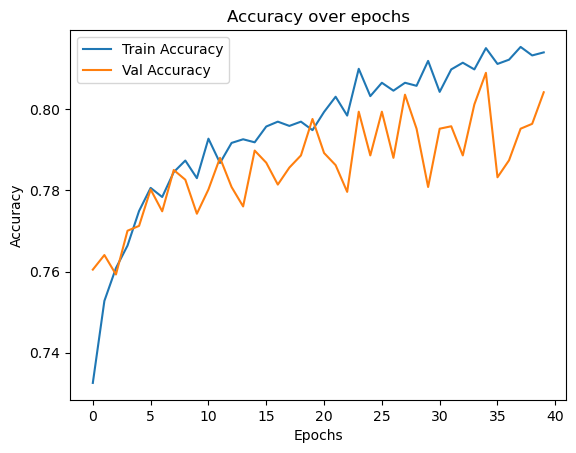

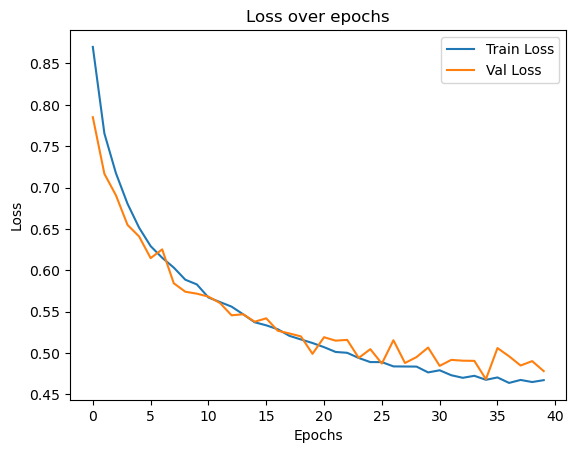

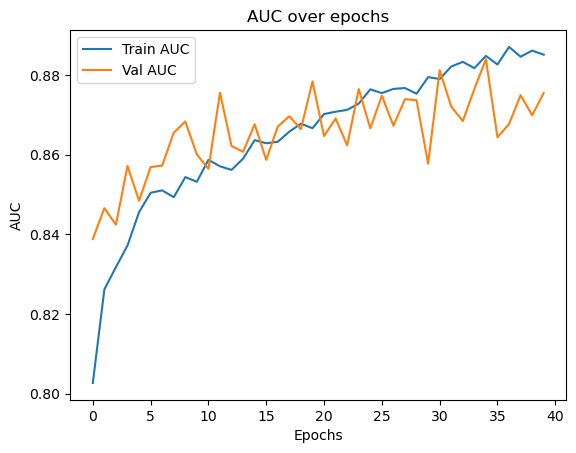

In [14]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot AUC if included in metrics
if 'auc' in history.history:
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.legend()
    plt.title('AUC over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.show()


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from tensorflow.keras.models import load_model

# Load best saved weights
#model.load_weights(r'C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\weights\best_model.weights.h5')

def evaluate_model(model, generator, steps, model_name="Model"):
    if hasattr(generator, 'on_epoch_end'):
        generator.on_epoch_end()

    y_true = []
    y_pred_prob = []
    
    for i in range(steps):
        if hasattr(generator, '__getitem__'):
            batch_x, batch_y = generator.__getitem__(i)
        else:
            batch_x, batch_y = next(generator.generate())
            
        batch_pred = model.predict(batch_x, verbose=0)
        
        y_true.extend(batch_y)
        y_pred_prob.extend(batch_pred)

    y_true = np.array(y_true).flatten()
    y_pred_prob = np.array(y_pred_prob).flatten()
    
    y_pred = (y_pred_prob > 0.5).astype(int)

    # --- Classification Report ---
    print(f"\n--- {model_name} Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Benign', 'Malignant'], rotation=45)
    plt.yticks(tick_marks, ['Benign', 'Malignant'])

    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    
    cm_path = fr'C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\result3_oversampled\oversampled_finished_confusion_matrix.png'
    plt.savefig(cm_path)
    print(f"Confusion matrix saved to: {cm_path}")
    plt.close()

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    
    roc_path = fr'C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\result3_oversampled\oversampled_finished_roc_curve.png'
    plt.savefig(roc_path)
    print(f"ROC curve saved to: {roc_path}")
    plt.close()

    return {
        'accuracy': (y_pred == y_true).mean(),
        'auc': roc_auc,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob,
        'confusion_matrix': cm
    }

results = evaluate_model(model, test_gen, len(test_gen), model_name="Oversampled_ResNet50")

print(f"\n Final Accuracy: {results['accuracy']:.4f}, AUC: {results['auc']:.4f}")

print("\nConfusion Matrix:")
print(results['confusion_matrix'])


--- Oversampled_ResNet50 Classification Report ---
              precision    recall  f1-score   support

      Benign       0.84      0.71      0.77       835
   Malignant       0.75      0.87      0.80       835

    accuracy                           0.79      1670
   macro avg       0.80      0.79      0.79      1670
weighted avg       0.80      0.79      0.79      1670

Confusion matrix saved to: C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\result3_oversampled\oversampled_finished_confusion_matrix.png
ROC curve saved to: C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\result3_oversampled\oversampled_finished_roc_curve.png

 Final Accuracy: 0.7892, AUC: 0.8721

Confusion Matrix:
[[594 241]
 [111 724]]
